In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15, 6]

In [2]:
characters = pd.read_csv("./data/personajes.csv")

In [3]:
## Veamos la primera visualizacion de nuestro dataset
characters

,S.No,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,...,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,...,0.0,0.0,NaN,0,0,11,1,1,0.605351,0
1,2,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1,1,1,1,1,0.896321,1
2,3,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,0,0,0,0.267559,1
3,4,Aemma Arryn,Queen,0,NaN,82.0,105.0,NaN,NaN,NaN,...,NaN,NaN,0.0,1,1,0,0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1,1,0,0,0,0.043478,1
5,6,Tommen Baratheon,NaN,1,NaN,NaN,NaN,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,...,1.0,1.0,NaN,0,0,5,1,1,1.000000,1
6,7,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,209.0,NaN,NaN,NaN,...,NaN,NaN,1.0,1,1,0,0,1,0.431438,0
7,8,Viserys I Targaryen,NaN,1,NaN,NaN,NaN,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,...,1.0,1.0,NaN,0,0,5,1,1,0.678930,0
8,9,Wilbert,Ser,1,NaN,NaN,298.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,0,0,0,0.006689,0
9,10,Wilbert Osgrey,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1,0,0,0,0.020067,1


In [4]:
## Y ahora por cada columna veamos un poco que info nos da pandas
for a in characters.columns:
    print(characters[a].describe())
    print("----------")

count    1946.000000
mean      973.500000
std       561.906131
min         1.000000
25%       487.250000
50%       973.500000
75%      1459.750000
max      1946.000000
Name: S.No, dtype: float64
----------
count             1946
unique            1946
top       Marq Grafton
freq                 1
Name: name, dtype: object
----------
count     938
unique    262
top       Ser
freq      384
Name: title, dtype: object
----------
count    1946.000000
mean        0.619219
std         0.485704
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: male, dtype: float64
----------
count          677
unique          64
top       Northmen
freq           124
Name: culture, dtype: object
----------
count       433.000000
mean       1577.364896
std       19565.414460
min         -28.000000
25%         240.000000
50%         268.000000
75%         285.000000
max      298299.000000
Name: dateOfBirth, dtype: float64
----------
count       444.0000

## Hay una relacion entre tener familiares muertos y la probabilidad de morir?

Agruparemos por la flag de "tengo familiares muertos" y si estoy vivo o no y contaremos cuantos elementos hay por bucket

In [5]:
characters.groupby(["boolDeadRelations", "isAlive"]).count()

S.No  name  title  male  culture  dateOfBirth  \
boolDeadRelations isAlive                                                  
0                 0         415   415    205   415      146          112   
                  1        1386  1386    640  1386      444          223   
1                 0          80    80     51    80       41           51   
                  1          65    65     42    65       46           47   

                           DateoFdeath  mother  father  heir     ...      \
boolDeadRelations isAlive                                        ...       
0                 0                385       3       4     2     ...       
                  1                  0       0       3     3     ...       
1                 0                 59      15      16    16     ...       
                  1                  0       3       3     2     ...       

                           book5  isAliveMother  isAliveFather  isAliveHeir  \
boolDeadRelations isAlive                                                     
0                 0          415              3              4            2   
                  1         1386              0              3            3   
1                 0           80             15             16           16   
                  1           65              3              3            2   

                           isAliveSpouse  isMarried  isNoble  \
boolDeadRelations isAlive                                      
0                 0                   52        415      415   
                  1                  164       1386     1386   
1                 0                   33         80       80   
                  1                   27         65       65   

                           numDeadRelations  isPopular  popularity  
boolDeadRelations isAlive                                           
0                 0                     415        415         415  
                  1                    1386       1386        1386  
1                 0                      80         80          80  
                  1                      65         65          65  

[4 rows x 26 columns]

Esto agrupa en cada columna, por lo cual usaremos 1 sola para el analisis, veamos como se veria:

In [6]:
data = characters.groupby(["boolDeadRelations", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data

isAlive,0,1
boolDeadRelations,,
0,415,1386
1,80,65


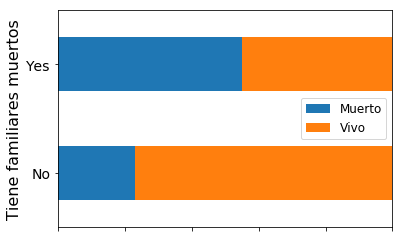

In [7]:
# Dividimos cada valor, por la suma del total en la row, para saber el porcentaje y no el valor absoluto.
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", ylabel = "Tiene familiares muertos"), p.legend(["Muerto", "Vivo"])

## Aparecer en más libros, aumenta la probabilidad de seguir vivo?

In [8]:
# Contaremos en cuantos libros esta cada personaje sumando las columnas, libro 1, 2, 3, 4, y 5
data = characters.copy(deep=True)
data.loc[:, "no_of_books"] = characters[['book1','book2','book3','book4','book5']].sum(axis = 1)
data = data.groupby(["no_of_books", "isAlive"]).count()["S.No"].unstack()
data

isAlive,0,1
no_of_books,,
0,121,151
1,133,530
2,62,269
3,70,216
4,53,129
5,56,156


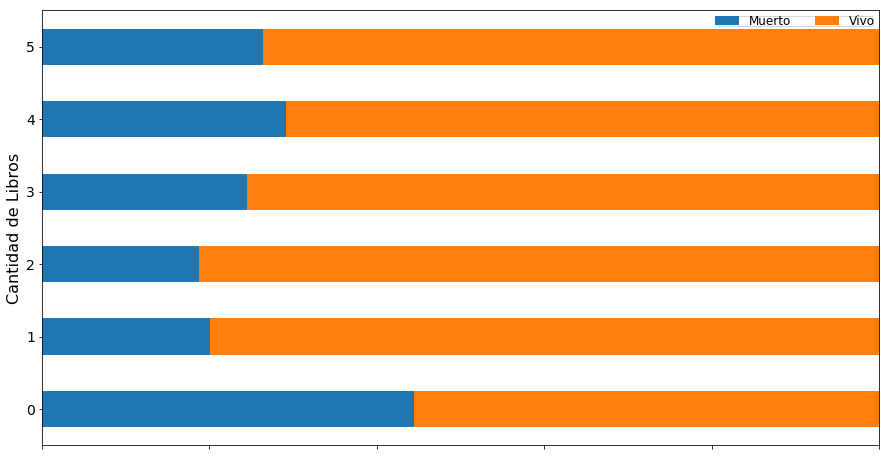

In [9]:
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "Cantidad de Libros"), p.legend(["Muerto", "Vivo"], loc = "upper right", ncol = 2, borderpad = -.15)

Vemos que si no se aparece en ningun libro, la probabilidad de estar muerto aumenta, lo mismo sucede a medida que vamos apareciendo en cada vez más libros.

## Los reyes y reina, son o no más propensos a morir?

In [10]:
# Veamos quienes son reyes y reinas
data= characters.copy(deep=True)
data["isKing"] = data.title.apply(lambda x: True if (not pd.isna(x)) and ('King' in x or 'Queen' in x) else False)
data = data.groupby(["isKing", "isAlive"]).count()["S.No"].unstack()
data

isAlive,0,1
isKing,,
False,481,1426
True,14,25


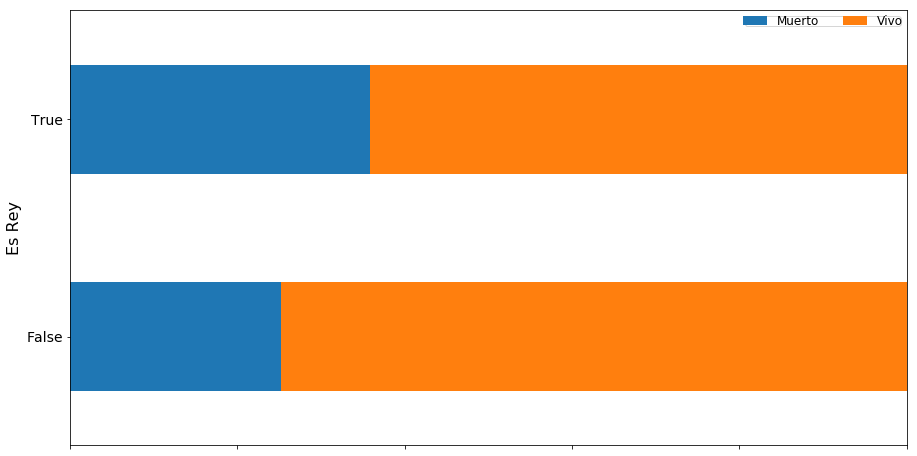

In [11]:
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "Es Rey"), p.legend(["Muerto", "Vivo"], loc = "upper right", ncol = 2, borderpad = -.15)

## La edad influye en la probabilidad de morir?

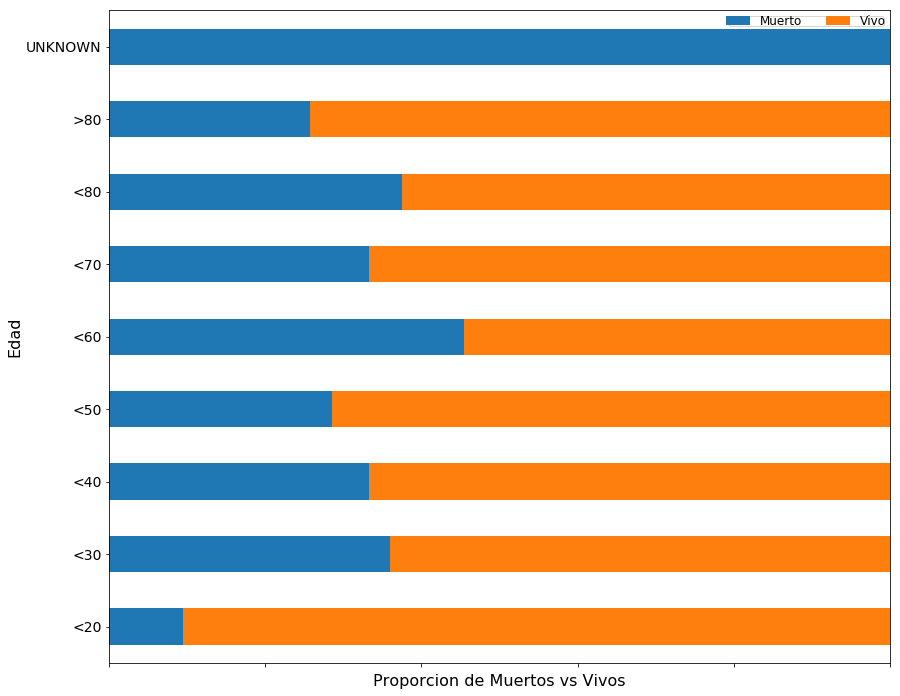

In [12]:
data = characters.copy(deep=True)
data["age"] = data.dateOfBirth.apply(lambda x: 300-x if x is not None else -1)
data["age_cluster"] = data.age.apply(lambda x: 'UNKNOWN' if x < 0 else '<20' if x <20 else '<30' if x <30 else '<40' if x <40 else '<50' if x <50 else '<60' if x <60 else '<70' if x <70 else '<80' if x <80 else '>80')
data_plot = data.groupby(["age_cluster", "isAlive"]).count()["S.No"].unstack()

p = data_plot.div(data_plot.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "Edad", xlabel = "Proporcion de Muertos vs Vivos"), p.legend(["Muerto", "Vivo"], loc = "upper right", ncol = 2, borderpad = -.15)

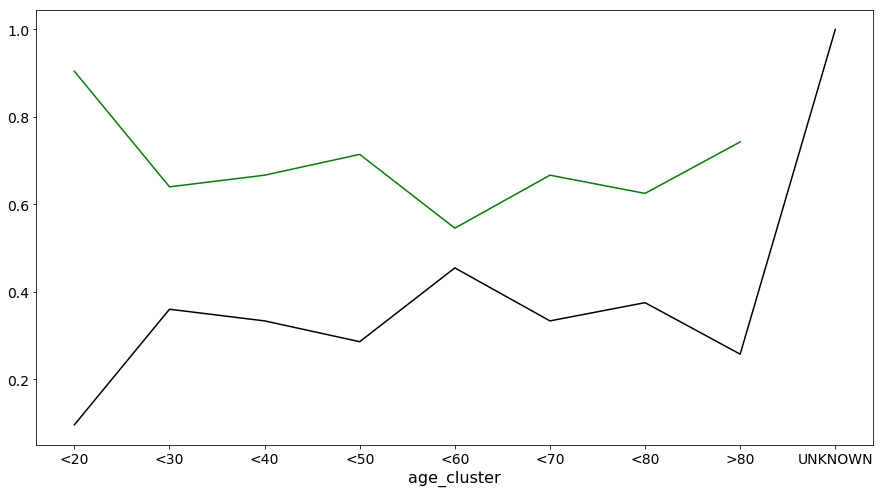

In [13]:
plt.figure(figsize=(15,8))
total_per_cluster = data.groupby('age_cluster').agg('count').name.reset_index(name='total')
dead_characters_per_cluster = data[characters.isAlive==0].groupby('age_cluster').agg('count').name.reset_index(name='counts') 
alive_characters_per_cluster = data[characters.isAlive==1].groupby('age_cluster').agg('count').name.reset_index(name='counts') 
ax = sns.lineplot(x=dead_characters_per_cluster.age_cluster, y=(dead_characters_per_cluster.counts/total_per_cluster.total), color='Black')
sns.lineplot(x=alive_characters_per_cluster.age_cluster, y=(alive_characters_per_cluster.counts/total_per_cluster.total), color='Green', ax=ax)

## Hay sociedades que sobreviven más que otras?
Veamos que sociedades tenemos

In [14]:
characters.culture.unique()

array([nan, 'Rivermen', 'Dornish', 'Valyrian', 'Ironborn', 'Free Folk',
       'Northmen', 'Summer Isles', 'Braavosi', 'Dothraki', 'Ghiscari',
       'Vale mountain clans', 'Reach', 'Tyroshi', 'Lhazarene', 'Free folk',
       'Ironmen', 'Qartheen', 'Lysene', 'westermen', 'Westerman', 'Qarth',
       'Lyseni', 'northmen', 'Qohor', 'Westeros', 'Norvoshi', 'First Men',
       'Meereenese', 'Andal', 'Astapori', 'Westermen', 'ironborn',
       'Ghiscaricari', 'Braavos', 'Stormlands', 'Valemen', 'Myrish',
       'Lhazareen', 'Dornishmen', 'Sistermen', 'Northern mountain clans',
       'Andals', 'Vale', 'Crannogmen', 'Wildling', 'Dorne', 'Pentoshi',
       'free folk', 'Summer Islander', 'Westerlands', 'Summer Islands',
       'Asshai', 'Riverlands', 'Naathi', 'Rhoynar', 'Meereen', 'Norvos',
       'Stormlander', 'Wildlings', 'Astapor', 'Reachmen', "Asshai'i",
       'Ibbenese', 'The Reach'], dtype=object)

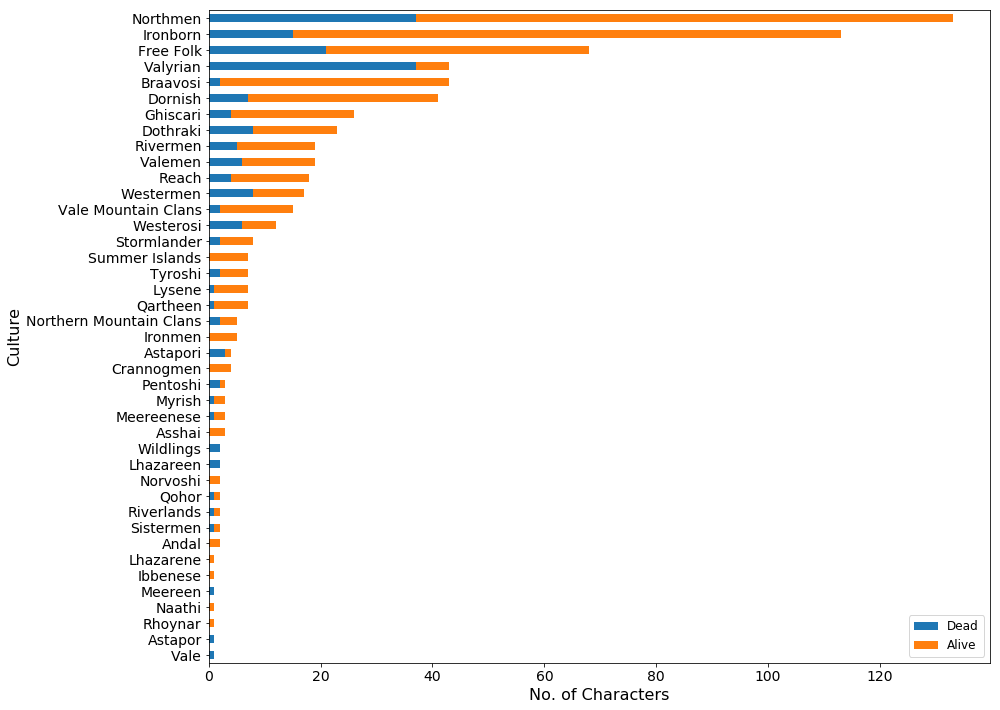

In [15]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()
x = characters.copy(deep=True)
x.loc[:, "culture"] = [get_cult(y) for y in x.culture.fillna("")]
data = x.groupby(["culture", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

## Cual es la proporción de personajes muertos vs los personajes vivos?

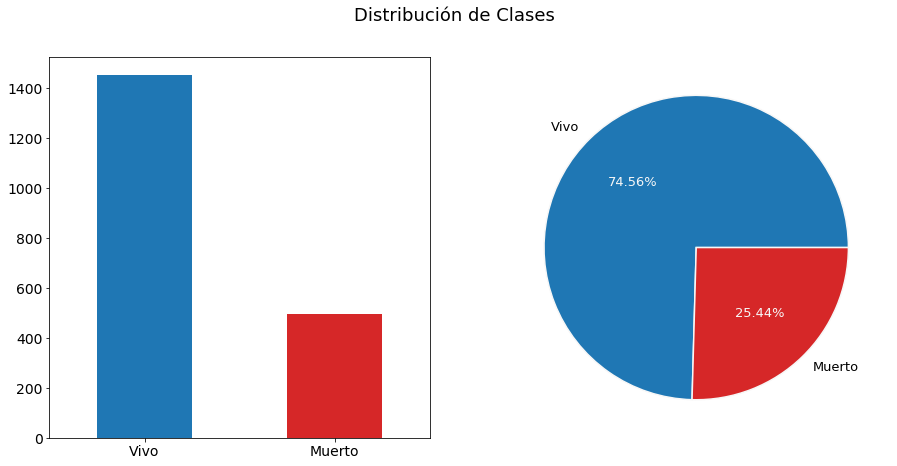

In [16]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Distribución de Clases", fontsize = 18.)
_ = characters.isAlive.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[3])).set(xticklabels = ["Vivo", "Muerto"])
_ = characters.isAlive.value_counts().plot.pie(labels = ("Vivo", "Muerto"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[3]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

In [105]:
# Hagamos una copia del dataset para empezar a prepararlo para entrenar
df_predictions = characters.copy(deep = True)

In [106]:
# Funcion auxiliar para armar los csv con las proporciones que queramos
def getClassSize(df, dead_p, alive_p):
    dead_count = df[df.isAlive == 0].shape[0]
    alive_count = df[df.isAlive == 1].shape[0]
    return round(dead_count*dead_p), round(alive_count*alive_p)

## Ahora que conocemos nuestro dataset, vamos a preprocesarlo
Xgboost no acepta variables categoricas asi como asi, todo debe pasar a numerico, por eso usaremos el metodo get_dummies de pandas, y a todo valor vacio le pondremos un default.

Veamos como funcionaria el get_dummies para la columna cultura

In [107]:
df_predictions.loc[:, "culture"] = [get_cult(x) for x in df_predictions.culture.fillna("UNKOWN")]
pd.get_dummies(df_predictions.culture).head(10)

,Andal,Asshai,Astapor,Astapori,Braavosi,Crannogmen,Dornish,Dothraki,Free Folk,Ghiscari,...,Summer Islands,Tyroshi,Unkown,Vale,Vale Mountain Clans,Valemen,Valyrian,Westermen,Westerosi,Wildlings
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Hay columnas para las cuales no queremos saber si que categoria es, sino solo pasar cada categoria a un número, por ejemplo la madre de cada personaje, podriamos numerarlas del -1 (NaN) a N. Para eso usaremos pd.factorize

In [108]:
pd.factorize(df_predictions.mother)

(array([ 0, -1, -1, ..., -1, -1, -1]),
 Index(['Rhaenyra Targaryen', 'Cersei Lannister', 'Alyssa Targaryen',
        'Visenya Targaryen', 'Catelyn Stark', 'Cassana Estermont',
        'Valaena Velaryon', 'Alicent Hightower', 'Rhaenys Targaryen',
        'Mariah Martell', 'Shaera Targaryen', 'Daenaera Velaryon',
        'Naerys Targaryen', 'Lady of House Sunderly', 'Betha Blackwood',
        'Alyssa Velaryon', 'Dyanna Dayne'],
       dtype='object'))

In [109]:
df_predictions = pd.concat([df_predictions, pd.get_dummies(df_predictions.culture)], axis=1)
df_predictions.loc[:, "mother"] = pd.factorize(df_predictions.mother)[0]
df_predictions.loc[:, "father"] = pd.factorize(df_predictions.father)[0]
df_predictions.loc[:, "heir"] = pd.factorize(df_predictions.heir)[0]
df_predictions.loc[:, "house"] = pd.factorize(df_predictions.house)[0]
df_predictions.loc[:, "spouse"] = pd.factorize(df_predictions.spouse)[0]
df_predictions.loc[:, "title"] = pd.factorize(df_predictions.title)[0]

df_predictions.drop(["name", "dateOfBirth", "DateoFdeath", "culture","S.No"], 1, inplace = True)
df_predictions.columns = map(lambda x: x.replace(".", "").replace("_", ""), df_predictions.columns)
df_predictions.fillna(value = -1, inplace = True)

## Veamos con que columnas vamos a contamos luego de las transformaciones
df_predictions.columns

Index(['title', 'male', 'mother', 'father', 'heir', 'house', 'spouse', 'book1',
       'book2', 'book3', 'book4', 'book5', 'isAliveMother', 'isAliveFather',
       'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble',
       'numDeadRelations', 'boolDeadRelations', 'isPopular', 'popularity',
       'isAlive', 'Andal', 'Asshai', 'Astapor', 'Astapori', 'Braavosi',
       'Crannogmen', 'Dornish', 'Dothraki', 'Free Folk', 'Ghiscari',
       'Ibbenese', 'Ironborn', 'Ironmen', 'Lhazareen', 'Lhazarene', 'Lysene',
       'Meereen', 'Meereenese', 'Myrish', 'Naathi', 'Northern Mountain Clans',
       'Northmen', 'Norvoshi', 'Pentoshi', 'Qartheen', 'Qohor', 'Reach',
       'Rhoynar', 'Riverlands', 'Rivermen', 'Sistermen', 'Stormlander',
       'Summer Islands', 'Tyroshi', 'Unkown', 'Vale', 'Vale Mountain Clans',
       'Valemen', 'Valyrian', 'Westermen', 'Westerosi', 'Wildlings'],
      dtype='object')

Vemos que tenemos una gran cantidad de personajes vivos pero no tantos que hayan muerto, esta diferencia de proprociones, podría generar que nuestro algoritmo tenga problemas para aprender las caracteristicas de la clase que menos apariciones tiene. Como hablamos esto puede solucionarse forzando el balanceo de las clases (subsample u oversampleo).



In [110]:
# Armamos la matriz de variables con las que entrenaremos
train_death_count, train_alive_count = getClassSize(df_predictions, 0.5, 0.5)

dead_train = df_predictions[df_predictions.isAlive == 0].sample(train_death_count, random_state = 62)
alive_train = df_predictions[df_predictions.isAlive == 1].sample(train_alive_count, random_state = 62)
X = dead_train.append(alive_train).copy(deep = True).astype(np.float64)
# Separamos la label que queremos mostrarle al entrenar
Y = X.isAlive.values

# Repetimos la misma partición pero para el conjunto de test
tX = df_predictions[~df_predictions.index.isin(X.index)].copy(deep = True).astype(np.float64)
tY = tX.isAlive.values

# Borramos la columna de la label del conjunto de entrenamiento y del conjunto de prediccion del test.
X.drop(["isAlive"], 1, inplace = True)
tX.drop(["isAlive"], 1, inplace = True)

In [111]:
# Entrenamos un Logistic Regression
clf_log = LogisticRegression(random_state = 14).fit(X, Y)
# Entrenamos un KNeighbors Classifier de K=5
clf_kneigh = KNeighborsClassifier(n_neighbors = 5).fit(X, Y)
# Entrenamos un XGB (eXtreme Gradient Boosted tree)
clf_tree = DecisionTreeClassifier().fit(X, Y)

# Para cada clasificador predecimos el test set
preds_log = clf_log.predict_proba(tX)
preds_neigh = clf_kneigh.predict_proba(tX)
preds_tree = clf_tree.predict_proba(tX)

# Veamos que variables fueron las más importantes

In [112]:
def plot_feature_importances(coef, columns, title):
    plt.rcParams["figure.figsize"] = [15, 6]
    feat_imp = pd.DataFrame({'importance':coef}) 
    feat_imp.reindex(feat_imp['importance'].abs().sort_values().index).set_index('importance')
    feat_imp['feature'] = columns
    feat_imp = feat_imp.iloc[:25]
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title)
    plt.xlabel('Feature Importance Score')
    plt.show()

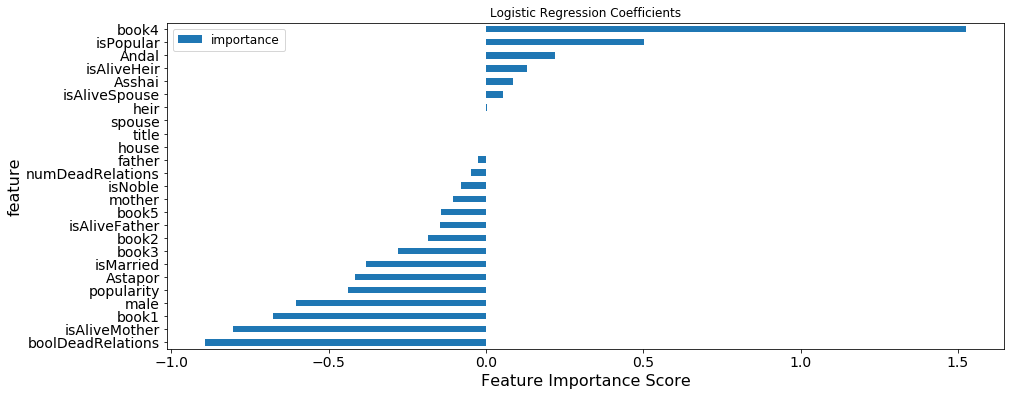

In [113]:
plot_feature_importances(clf_log.coef_[0], tX.columns, 'Logistic Regression Coefficients')

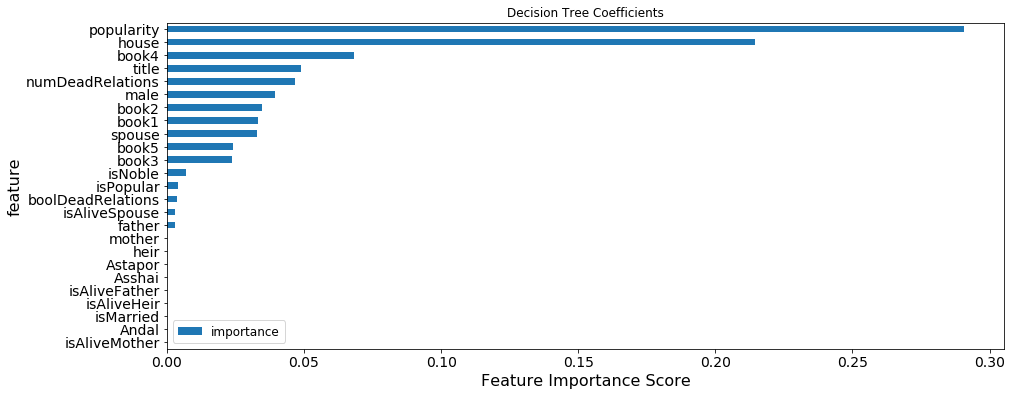

In [114]:
plot_feature_importances(clf_tree.feature_importances_, tX.columns, 'Decision Tree Coefficients')

## Comparando Logistic Regression vs KNN vs Decision Tree

### Matriz de Confusión


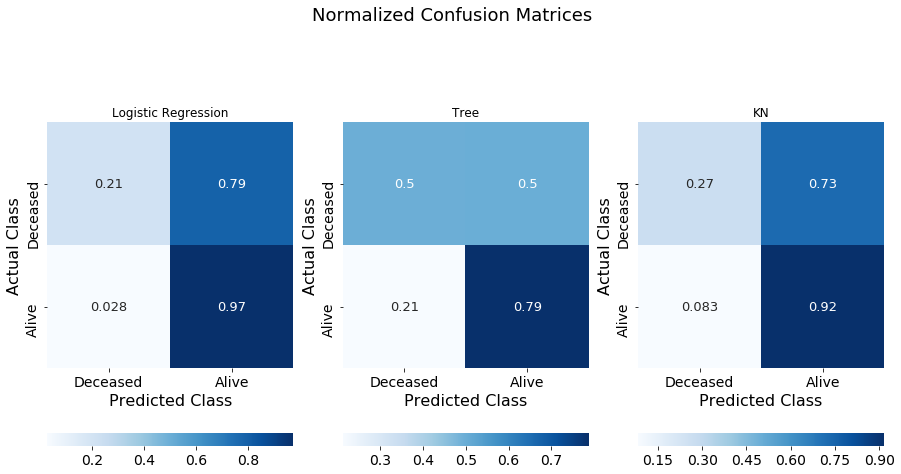

In [115]:
f, ax = plt.subplots(1, 3, figsize = (15, 8))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(
        xlabel = "Predicted Class", ylabel = "Actual Class", title = t)
make_cm(preds_log, "Logistic Regression", 0)
make_cm(preds_tree, "Tree", 1)
make_cm(preds_neigh, "KN", 2)

## Cuál es mejor modelo? 

### Scorecard
Veamos algunas metricas, por ejemplo AUC, log loss, precision.

In [116]:
def metricas(tY, predicted_y, title):
    print(title+ "\n" + "-" * 25 + "\n", classification_report(tY, np.argmax(predicted_y, axis = 1), target_names = ["Deceased", "Alive"]))
    print("AUC      : %.4f" % roc_auc_score(tY, predicted_y[:, 1]))
    print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(predicted_y, axis = 1)))
    print("Log Loss : %.4f\n\n" % log_loss(tY, predicted_y[:, 1]))

In [117]:
metricas(tY, preds_log, "Logistic Regression")
metricas(tY, preds_tree, "Decision Tree")
metricas(tY, preds_neigh, "K Neighbour")

Logistic Regression
-------------------------
              precision    recall  f1-score   support

   Deceased       0.72      0.21      0.33       247
      Alive       0.78      0.97      0.87       725

avg / total       0.77      0.78      0.73       972

AUC      : 0.7582
Accuracy : 0.7788
Log Loss : 0.4808


Decision Tree
-------------------------
              precision    recall  f1-score   support

   Deceased       0.44      0.50      0.47       247
      Alive       0.82      0.79      0.80       725

avg / total       0.73      0.71      0.72       972

AUC      : 0.6444
Accuracy : 0.7140
Log Loss : 9.6700


K Neighbour
-------------------------
              precision    recall  f1-score   support

   Deceased       0.53      0.27      0.36       247
      Alive       0.79      0.92      0.85       725

avg / total       0.72      0.75      0.72       972

AUC      : 0.6535
Accuracy : 0.7531
Log Loss : 2.2741




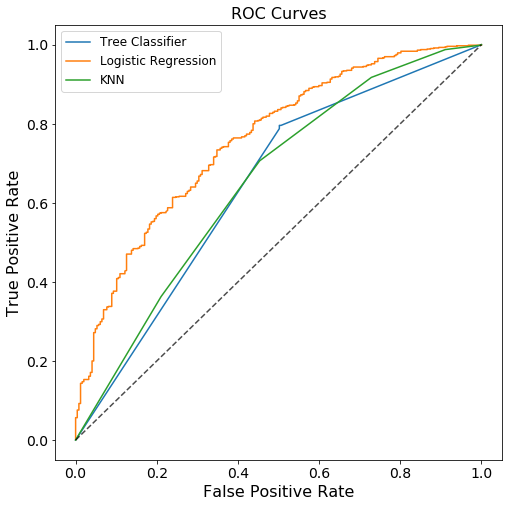

In [118]:
tree_roc = roc_curve(tY, preds_tree[:, 1])
log_roc = roc_curve(tY, preds_log[:, 1])
knn_roc = roc_curve(tY, preds_neigh[:, 1])
_ = plt.figure(figsize = (8, 8)), plt.plot(*tree_roc[:2]), plt.plot(*log_roc[:2], c = sns.color_palette()[1]),plt.plot(*knn_roc[:2], c = sns.color_palette()[2]), plt.legend(["Tree Classifier", "Logistic Regression", "KNN"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

In [119]:
from sklearn.metrics import auc
optimal_idx = np.argmax(log_roc[1] - log_roc[0])
optimal_threshold = log_roc[2][optimal_idx]
print(optimal_threshold)


0.720271570183


# La idea ahora es probar:
 - variantes de columnas
 - ratio de training vs test
 - hiperparametros de los algoritmos

In [120]:
df_predictions_plus = characters.copy(deep = True)

In [121]:
df_predictions_plus.loc[:, "culture"] = [get_cult(x) for x in df_predictions_plus.culture.fillna("UNKOWN")]
df_predictions_plus.loc[:, "culture"] = pd.factorize(df_predictions_plus.culture)[0]
df_predictions_plus.loc[:, "mother"] = pd.factorize(df_predictions_plus.mother)[0]
df_predictions_plus.loc[:, "father"] = pd.factorize(df_predictions_plus.father)[0]
df_predictions_plus.loc[:, "heir"] = pd.factorize(df_predictions_plus.heir)[0]
df_predictions_plus.loc[:, "house"] = pd.factorize(df_predictions_plus.house)[0]
df_predictions_plus.loc[:, "spouse"] = pd.factorize(df_predictions_plus.spouse)[0]
df_predictions_plus.loc[:, "isKing"] = df_predictions_plus.title.apply(lambda x: True if (not pd.isna(x)) and ('King' in x or 'Queen' in x) else False)
df_predictions_plus.loc[:, "title"] = pd.factorize(df_predictions_plus.title)[0]
df_predictions_plus.loc[:, "age"] = df_predictions_plus.dateOfBirth.apply(lambda x: 300-x if x is not None else -1)
df_predictions_plus.loc[:, "no_of_books"] = df_predictions_plus[['book1','book2','book3','book4','book5']].sum(axis = 1)

df_predictions_plus.drop(["name", "dateOfBirth", "DateoFdeath", "S.No"], 1, inplace = True)
df_predictions_plus.columns = map(lambda x: x.replace(".", "").replace("_", ""), df_predictions_plus.columns)
df_predictions_plus.fillna(value = -1, inplace = True)
df_predictions_plus.columns

Index(['title', 'male', 'culture', 'mother', 'father', 'heir', 'house',
       'spouse', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother',
       'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble',
       'numDeadRelations', 'boolDeadRelations', 'isPopular', 'popularity',
       'isAlive', 'isKing', 'age', 'noofbooks'],
      dtype='object')

In [122]:
# Armamos la matriz de variables con las que entrenaremos
train_death_count, train_alive_count = getClassSize(df_predictions_plus,0.8,0.8)
X_plus = df_predictions_plus[df_predictions_plus.isAlive == 0].sample(train_death_count, random_state = 62).append(df_predictions_plus[df_predictions_plus.isAlive == 1].sample(train_alive_count, random_state = 62)).copy(deep = True).astype(np.float64)
# Separamos la label que queremos mostrarle al entrenar
Y_plus = X_plus.isAlive.values

# Repetimos la misma partición pero para el conjunto de test
tX_plus = df_predictions_plus[~df_predictions_plus.index.isin(X_plus.index)].copy(deep = True).astype(np.float64)

tY_plus = tX_plus.isAlive.values

# Borramos la columna de la label del conjunto de entrenamiento y del conjunto de prediccion del test.
X_plus.drop(["isAlive"], 1, inplace = True)
tX_plus.drop(["isAlive"], 1, inplace = True)

In [123]:
# Entrenamos un Logistic Regression
clf_log = LogisticRegression(random_state = 14).fit(X_plus, Y_plus)
# Entrenamos un KNeighbors Classifier de K=5
clf_kneigh = KNeighborsClassifier(n_neighbors = 5).fit(X_plus, Y_plus)
# Entrenamos un XGB (eXtreme Gradient Boosted tree)
clf_tree = DecisionTreeClassifier(random_state = 14).fit(X_plus, Y_plus)

# Para cada clasificador predecimos el test set
preds_log = clf_log.predict_proba(tX_plus)
preds_neigh = clf_kneigh.predict_proba(tX_plus)
preds_tree = clf_tree.predict_proba(tX_plus)

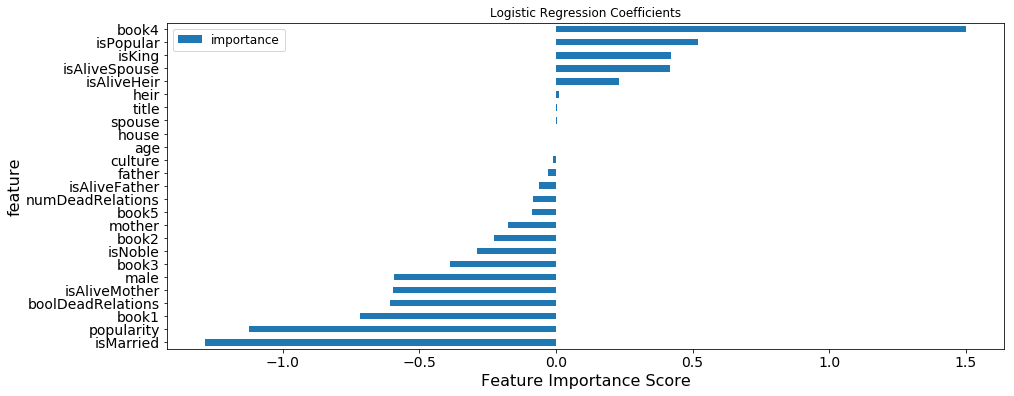

In [124]:
plot_feature_importances(clf_log.coef_[0], tX_plus.columns, 'Logistic Regression Coefficients')

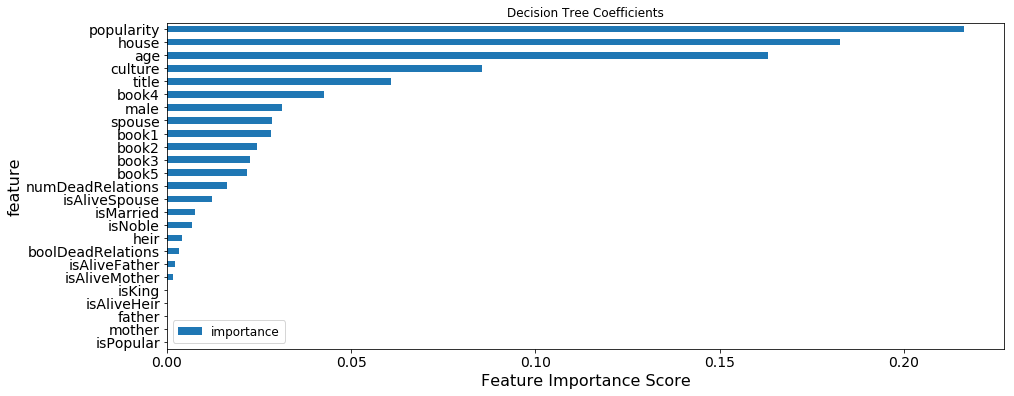

In [125]:
plot_feature_importances(clf_tree.feature_importances_, tX_plus.columns, 'Decision Tree Coefficients')

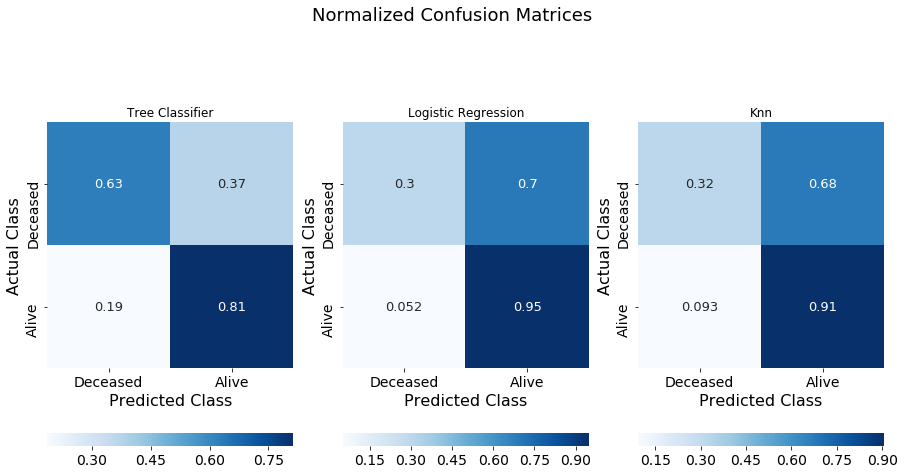

In [126]:
f, ax = plt.subplots(1, 3, figsize = (15, 8))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY_plus, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(
        xlabel = "Predicted Class", ylabel = "Actual Class", title = t)
make_cm(preds_tree, "Tree Classifier", 0)
make_cm(preds_log, "Logistic Regression", 1)
make_cm(preds_neigh, "Knn", 2)

In [127]:
metricas(tY_plus, preds_log, "Logistic Regression")
metricas(tY_plus, preds_tree, "Decision Tree")
metricas(tY_plus, preds_neigh, "K Neighbour")

Logistic Regression
-------------------------
              precision    recall  f1-score   support

   Deceased       0.67      0.30      0.42        99
      Alive       0.80      0.95      0.87       290

avg / total       0.77      0.78      0.75       389

AUC      : 0.7521
Accuracy : 0.7841
Log Loss : 0.4923


Decision Tree
-------------------------
              precision    recall  f1-score   support

   Deceased       0.53      0.63      0.58        99
      Alive       0.86      0.81      0.84       290

avg / total       0.78      0.77      0.77       389

AUC      : 0.7237
Accuracy : 0.7661
Log Loss : 7.7329


K Neighbour
-------------------------
              precision    recall  f1-score   support

   Deceased       0.54      0.32      0.41        99
      Alive       0.80      0.91      0.85       290

avg / total       0.73      0.76      0.74       389

AUC      : 0.7110
Accuracy : 0.7584
Log Loss : 1.4766




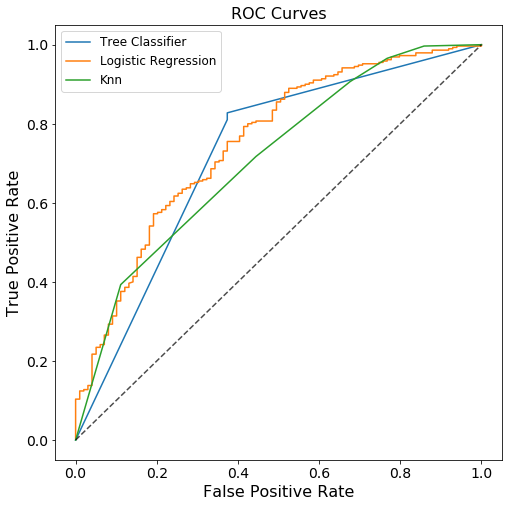

In [128]:
tree_roc_plus = roc_curve(tY_plus, preds_tree[:, 1])
log_roc_plus = roc_curve(tY_plus, preds_log[:, 1])
knn_roc_plus = roc_curve(tY_plus, preds_neigh[:, 1])

_ = plt.figure(figsize = (8, 8)), plt.plot(*tree_roc_plus[:2]), plt.plot(*log_roc_plus[:2],c = sns.color_palette()[1]), plt.plot(*knn_roc_plus[:2], c = sns.color_palette()[2]), plt.legend(["Tree Classifier", "Logistic Regression", "Knn"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

In [129]:
def metrics_detail(threshold,dfx, dfy, clf):
    tp=0
    fp=0
    tn=0
    fn=0
    row_count = dfx.shape[0]
    for x in range (0, row_count):
        predict_row = np.array(dfx.iloc[x]).reshape(1,-1)
        y_techo = clf.predict_proba(predict_row)
        prob = round(y_techo[0][1],5)
        prob_label = 'ALIVE' if prob > threshold else 'DEAD'
        real_label = 'ALIVE' if dfy[x] >0.5 else 'DEAD' 
        if (prob_label==real_label and prob_label=='ALIVE'):
            tn=tn+1
        elif(prob_label==real_label and prob_label=='DEAD'):
            tp = tp+1
        elif(prob_label!=real_label and prob_label=='DEAD'):
            fp = fp+1
            #print("Error with %s was predicted as %s and reality is %s" % (characters.iloc[x]['name'], prob_label,real_label))
        elif(prob_label!=real_label and prob_label=='ALIVE'):
            fn = fn+1
            #print("Error with %s was predicted as %s and reality is %s" % (characters.iloc[x]['name'], prob_label,real_label))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * ((precision*recall)/(precision+recall))
    print("\n\nThreshold %s -> F1 score = %s, Precision = %s, Recall = %s" % (threshold, round(f1,2), round(precision,2), round(recall,2)))

In [166]:
metrics_detail(0.65, tX_plus, tY_plus, clf_log)
metrics_detail(0.50, tX_plus, tY_plus, clf_tree)
metrics_detail(0.80, tX_plus, tY_plus, clf_kneigh)



Threshold 0.65 -> F1 score = 0.53, Precision = 0.48, Recall = 0.59


Threshold 0.5 -> F1 score = 0.58, Precision = 0.53, Recall = 0.63


Threshold 0.8 -> F1 score = 0.48, Precision = 0.33, Recall = 0.89
